# Classification

In Chapter 1, we mentioned that most common supervised learning tasks are regression (predicting values) & classification (predicting classes). In Chapter 2, we explored a regression task, predicting housing values, using various algorithms such as linear regression task, predicting housing values, using various algorithms such as linear regression, decision tree, & random forests. Now we will turn our attention to classification systems.

---

# MNIST 

In this chapter, we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students & employees of the US Census Bureau. Each image is labedl with the digit it represents. This set has ben studied so much that it is often called the "Hello World" of machine learning: whenever people come up with a new classification algorithm, they are curious to see how it will perform on MNIST. Whenever someone learns machine learning, sooner or later, they tackle MNIST.

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset:

In [6]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version = 1, as_frame = False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including:

* a `DESCR` key describing the dataset
* a `data` key containing an array with one row per instance & one column per feature
* a `target` key containing an array with the labels

Let's look at these arrays:

In [7]:
X, y = mnist["data"], mnist["target"]
print("X.shape: {}".format(X.shape))
print("y.shape: {}".format(y.shape))

X.shape: (70000, 784)
y.shape: (70000,)


There are 70,000 images, & each image has 784 features. This is because each image is 28x28 pixels, & each feature simply represents one pixel's intensity, from 0 (white) & 255 (black). Let's take a peek at one digit from the dataset. All you need to do is grab an instance's feature vector, reshape it to a 28x28 array, & display it using matplotlib's `imshow()` function.

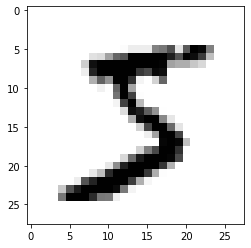

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")

This looks like a 5, & indeed, that's what the label tells us.

In [15]:
y[0]

5

Note that the label is a string. Since machine learning algorithms prefer numbers, let's cast `y` to integers.

In [16]:
import numpy as np

y = y.astype(np.uint8)
y[0]

5

The below figure shows a few more images from the MNIST dataset to give you a feel for the complexity of the classification task.

<img src = "Images/MNIST.png" alt = "Alternative text" width = "500" style = "margin:auto"/>

But wait! You should always create a test set & set it aside before inspecting the data closely. The MNIST dataset is actually already split into a training set (the first 60,000 images) & a test set (the last 10,000 images).

In [17]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good as this guarantees that all cross-validation folds will be similar (you don't want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, & they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won't happen.

---

# Training a Binary Classifier

Let's simplify the problem for now & only try to identify one digit -- for example, the number 5. This "5-detector" will be an example of a *binary classifier*, capable of distinguishing between just two classes, 5 & not 5. Let's create the target vectors for this classification task.

In [18]:
# Return True if training set label == 5.
y_train_5 = (y_train == 5)

# Return True if testing set label == 5.
y_test_5 = (y_test == 5)

Okay, now let's pick a classifier & train it. A good place to start is with a *Stochastic Gradient Descent* (SGD) classifier, using Scikit-Learn's `SGDClassifier` class. This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for *online learning*). Let's create an `SGDClassifier` & train it on the whole training set.

In [20]:
from sklearn.linear_model import SGDClassifier

# Create a SGD classifier instance.
sgd_clf = SGDClassifier(random_state = 42)

# Fit the SGD classifier instance to the training set.
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now you can use it to detect images of the number 5:

In [21]:
# Use the SGD classifier to predict the class of some_digit.
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (`True`). Looks like it guessed right in this particular case! Now, let's evaluate this model's performance.

---

# Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a large part of this chapter on this topic. There are many performance measures available so buckle down.

## Measuring Accuracy Using Cross-Validation

A good way to evaluate a model is to use cross-validation. Let's use the `cross_cal_score()` function to evaluate your `SGDClassifier` model using K-fold cross-validation, with 5 folds. Remembers that K-fold cross-validation means splitting the training set into K-folds (in this case, 5), then making predictions & evaluating them on each fold using a model trained on the remaining folds.

In [22]:
from sklearn.model_selection import cross_val_score

# Evaluate the accuracy of our SGD classifier by cross-validating the SGD classifier.
cross_val_score(sgd_clf, X_train, y_train_5, cv = 5, scoring = "accuracy")

array([0.95466667, 0.96975   , 0.9635    , 0.96533333, 0.94841667])

Wow! We get ~95% or more *accuracy* (ratio of correct predictions) on all cross-validation folds. This looks amazing! Well, before we get too excited, let's look at a very dumb classifier that just classifies every single image in the "not 5" class.

In [23]:
from sklearn.base import BaseEstimator

# Define the object class.
class Never5Classifier(BaseEstimator):
    # Does nothing.
    def fit(self, X, y = None):
        pass
    # Returns an array the length of the training set, filled with only zeros.
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

Can you guess this model's accuracy? Let's find out.

In [24]:
never_5_clf = Never5Classifier()

# Evaluate the accuracy of our newly defined classifier by cross-validating it.
cross_val_score(never_5_clf, X_train, y_train_5, cv = 5, scoring = "accuracy")

array([0.91266667, 0.90866667, 0.9095    , 0.90883333, 0.90858333])

That's right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.  This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with *skewed datasets* (i.e., when some classes are much more frequent than others).

## Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the *confusion matrix*. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row & 3rd column of the confusion matrix. 

To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. You could make predictions on the test set, but let's keep it untouched for now (remember tht you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the `cross_val_predict()` function.

In [25]:
from sklearn.model_selection import cross_val_predict

# Generate cross-validated predictions of our training set.
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 5)
y_train_pred

array([ True, False, False, ...,  True, False, False])

Just like the `cross_val_score()` function, `cross_val_predict()` performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set ("clean" meaning that the prediction is made by a model that never saw the data during training).

Now you are ready to get the confusion matrix using the `confusion_matrix()` function. Just pass it the target classes (`y_train_5`) & the predicted classes (`y_train_pred`).

In [26]:
from sklearn.metrics import confusion_matrix

# Creates a confusion matrix for the training set.
confusion_matrix(y_train_5, y_train_pred)

array([[53115,  1464],
       [  916,  4505]])

Each row in a confusion matrix represents an *actual class*, while each column represents a *predicted class*. The first row of this matrix considers non 5 images (the *negative class*): 53,763 of them were correctly classified as non 5s (they are called *true negatives*), while the remaining 816 were wrongly classified as 5s (*false positives*). The second row considers the images of 5s (the *positive class*): 1,372 were wrongly classified as non 5s (*false negatives*), while the remaining 4,049 were correctly classified as 5s (*true positives*). A perfect classifier would have only true positives & true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left & bottom right).

The confusion matrix gives you a lot of information, but sometimes, you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the *precision* of the classifier.

$$precision = \frac{TP}{TP + FP}$$

TP is the number of true positives, & FP is the number of false positives. A trivial way to have perfect precision is to make one single positive prediction & ensure it is correct (precision = 1/1 = 100%). This would not be very useful since the classifier would ignore all but one positive instance. So precision is typically used along with another metric named *recall*, also called *sensitivity* or *true positive rate* (TPR): this is the ratio of positive instances that are correctly detected by the classifier.

$$recall = \frac{TP}{TP + FN}$$

FN is the number of false negatives. 

If you are confused about confusion matrices, the below figure may help.

<img src = "Images/Confusion Matrix.png" alt = "Alternative text" width = "500" style = "margin:auto"/>

## Precision & Recall

Scikit-Learn provides several functions to compute classifier metrics, including precision & recall.

In [27]:
from sklearn.metrics import precision_score, recall_score

# Calculate precision & recall scores.
ps = round(precision_score(y_train_5, y_train_pred), 4)
rs = round(recall_score(y_train_5, y_train_pred), 4)
print("Precision Score: {}, Recall Score: {}".format(ps, rs))

Precision Score: 0.7547, Recall Score: 0.831


Now, our 5-detector does not look as good as it did when we looked at its accuracy. When it claims an image represents a 5, it is correct only 74.7% of the time. Moreover, it only detects 83.3% of the 5s.

It is often convenient to combine precision & recall into a single metric called the $F_1$ *score*, in particular if you need a simple way to compare two classifiers. The $F_1$ score is the *harmonic mean* of precision & recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high $F_1$ score if both recall & precision are high.

$$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 * \frac{precision * recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$$

To compute the $F_1$ score, simply call the `f1_score()` function.

In [28]:
from sklearn.metrics import f1_score

# Calculate F1 score.
round(f1_score(y_train_5, y_train_pred), 4)

0.791

The $F_1$ score favors classifiers that have similar precision & recall. This is not always what you want: in some context you mostly care about precision, & in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier's video selection). On the other hand, suppose you train a classifier to detect shoplifters on surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can't have it both ways: increasing precision reduces recall, & vice versa. This is called the *precision/recall tradeoff*.

## Precision/Recall Tradeoff

To understand this tradeoff, let's look at how the `SGDClassifier` makes it classification decision. For each instance, it computes a score based on a *decision function*, & if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class. The following figure shows a few digits positioned from the lowest score on the left to the highest score on the right. Suppose the *decision threshold* is positioned at the central arrow (between the two 5s): you will find 4 true positives (actual 5s), on the right of the threshold, & one false positive (actually a 6). Therefore, with that threshold, the precision is 80% (4 out of 5). But out of 6 actual 5s, the classifier only detects 4, so the recall is 67% (4 out of 6). Now if you raise the threshold (move it to the arrow on the right), the false positive (the 6) becomes a true negative, thereby increasing precision (up to 100% in this case), but one true positive becomes a false negative, decreasing recall down to 50%. Conversely, lowering the threhold increases recall & reduces precision.

<img src = "Images/Precision Recall Tradeoff.png" alt = "Alternative text" width = "500" style = "margine:auto"/>

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier's `predict()` method, you can call its `decision_function()` method, which returns a score for each instance, & then makes predictions based on those scores using any threshold you want.

In [29]:
# Predict confidence score for some_digit. The confidence score for any sample is proportional 
# to the signed distance of that sample to the hyperplane.
y_scores = np.around(sgd_clf.decision_function([some_digit]), 2)

# Return True if the confidence score is greater than the threshold.
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print("y_scores: {}, y_some_digit_pred: {}".format(y_scores, y_some_digit_pred))

y_scores: [2164.22], y_some_digit_pred: [ True]


The `SGDClassifier` uses a threshold equal to 0, so the previous code returns the same results as the `predict()` method (i.e., `True`). Let's raise the threshold.

In [30]:
# Change the threshold.
threshold = 8000

# Return True if the confidence score is greater than the threshold.
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 5, & the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8,000.

Now how do you decide which threshold to use? For this, you will first need to get the scores of all instances in the training set using the `cross_val_predict()` function again, but this time specifying that you want it to return decision scores instead of predictions.

In [31]:
# Generate the cross-validated confidence score for each sample in the training set.
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 5, method = "decision_function")
y_scores

array([  4411.53413566, -14087.12193543, -21565.51993633, ...,
         9394.4695853 ,  -2918.25117218,  -9160.6081938 ])

Now with these scores, you can compute precision & recall for all possible thresholds using the `precision_recall_curve()` function.

In [32]:
from sklearn.metrics import precision_recall_curve

# Generate precision-recall pairs for different probability thresholds.
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, you can plot precision & recall as functions of the threshold value using matplotlib.

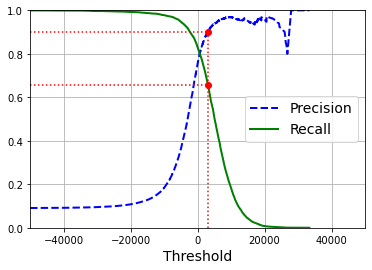

In [33]:
# Define a function.
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    
    # Plot the precision scores across thresholds with a blue dashed line, labeled "Precision".
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision", linewidth = 2)
    
    # Plot the recall scores across thresholds with a green solid line, labeled "Recall".
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall", linewidth = 2)
    
    # Fix the legend to the center right of the visualisation.
    plt.legend(loc = "center right", fontsize = 14)
    
    # Label the x-axis "Threshold".
    plt.xlabel("Threshold", fontsize = 14)
    
    # Add a grid background.
    plt.grid(True)
    
    # Limit the x-axis from -50000 to 50000 & the y-axis from 0 to 1.
    plt.axis([-50000, 50000, 0, 1])
    
# Suppose we want our precision score to be >= 90%, get recall & threshold for precision = 90%.
recall_90_precision = recalls[np.argmax(precisions >= 0.9)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

# Call the newly defined function.
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

# Plot red dotted line from (threshold_90_precision, 0) to (threshold_90_precision, 0.9).
plt.plot([threshold_90_precision, threshold_90_precision], [0, 0.9], "r:")

# Plot red dotted line from (-50000, 0.9) to (threshold_90_precision, 0.9).
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")

# Plot red dotted line from (-50000, recall_90_precision) to (threshold_90_precision, recall_90_precision).
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")

# Plot a point at (threshold_90_precision, 0.9).
plt.plot([threshold_90_precision], [0.9], "ro")

# Plot a red point at (threshold_90_precision, recall_90_precision).
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

Another way to select a good precision/recall tradeoff is to plot precision directly against recall, as shown in the figure below.

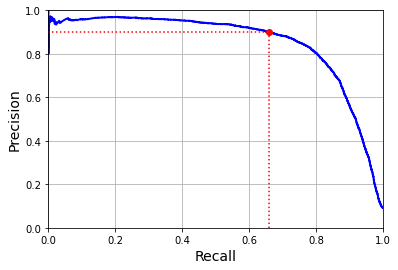

In [34]:
# Define a function.
def plot_precision_vs_recall(precisions, recalls):
    
    # Plot the precision scores against recall scores with a blue solid line.
    plt.plot(recalls, precisions, "b-", linewidth = 2)
    
    # Label the x-axis "Recall".
    plt.xlabel("Recall", fontsize = 14)
    
    # Label the y-axis "Precision".
    plt.ylabel("Precision", fontsize = 14)
    
    # Limit both the x & y-axes to 0 & 1.
    plt.axis([0, 1, 0, 1])
    
    # Add a grid background.
    plt.grid(True)

# Call the newly defined function.
plot_precision_vs_recall(precisions, recalls)

# Plot a red dotted line from (recall_90_precision, 0) to (recall_90_precision, 0.9).
plt.plot([recall_90_precision, recall_90_precision], [0, 0.9], "r:")

# Plot a red dotted line from (0, 0.9) to (recall_90_precision, 0.9).
plt.plot([0, recall_90_precision], [0.9, 0.9], "r:")

# Plot a red point at (recall_90_precision, 0.9).
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

You can see that precision starts to fall sharply around 80% recall. You will probably want to select a precision/recall tradeoff just before that drop -- for example, at around 60% recall. But of course, the choice depends on your project.

So let's suppose you decide to aim for 90% precision. You look up the first plot & find that you need to use a threshold of about 8,000. To be more precise you can search for the lowest threshold that gives you at least 90% precision (`np.argmax()` will give us the first index of the maximum value, which in this case means the first `True` value):

In [35]:
# The threshold we want our confidence scores to be greater than if we want >= 90% precision.
round(threshold_90_precision, 2)

3045.93

To make predictions (on the training set for now), instead of calling the classifier's `predict()` method, you can do the following.

In [36]:
# Returns True if training set labels' confidence scores are greater than the 90% precision threshold.
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([ True, False, False, ...,  True, False, False])

Let's check these predictions' precision & recall:

In [37]:
# Generate the precision & recall scores.
ps = round(precision_score(y_train_5, y_train_pred_90), 4)
rs = round(recall_score(y_train_5, y_train_pred_90), 4)
print("Precision Score: {}, Recall Score: {}".format(ps, rs))

Precision Score: 0.9002, Recall Score: 0.6589


Great, you now have a 90% precision classifier! As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, & you're done. Hmm, not so fast. A high-precision classifier is not very useful if its recall is too low.

## The ROC Curve

The *receiver operating characteristic* (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC plots the *true positive rate* (another name for recall) against the *false positive rate* (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the *true negative rate* (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called *specificity*. Hence, the ROC curve plots *sensitivity* (recall) versus 1 - *specificity*.

To plot the ROC curve, you first need to compute the TPR & FPR for various threshold values, using the `roc_curve()` function.

In [38]:
from sklearn.metrics import roc_curve

# Computes the true positive rate & false positive rate for the ROC curve.
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Then you can plot the FPR against the TPR using matplotlib. 

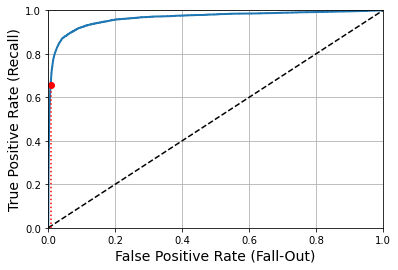

In [39]:
# Define a function.
def plot_roc_curve(fpr, tpr, label = None):
    
    # Plot true positive rate across false positive rates.
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    
    # Plot a black dashed line from (0, 0) to (1, 1).
    plt.plot([0, 1], [0, 1], "k--")
    
    # Limit both x & y-axes to between 0 & 1.
    plt.axis([0, 1, 0, 1])
    
    # Label the x-axis "False Positive Rate (Fall-Out)".
    plt.xlabel("False Positive Rate (Fall-Out)", fontsize = 14)
    
    # Label the y-axis "True Positive Rate (Recall)".
    plt.ylabel("True Positive Rate (Recall)", fontsize = 14)
    
    # Add a grid background.
    plt.grid(True)

# Call the newly defined function.
plot_roc_curve(fpr, tpr)

# Find the false positive rate when the true positive rate (recall) is greater than recall_90_precision.
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]

# Plot a red dotted line from (fpr_90, 0) to (fpr_90, recall_90_precision).
plt.plot([fpr_90, fpr_90], [0, recall_90_precision], "r:")

# Plot a red dotted line from (0, recall_90_precision) to (fpr_90, recall_90_precision).
plt.plot([0, fpr_90], [recall_90_precision, recall_90_precision], "r:")

# Plot a red point at (fpr_90, recall_90_precision).
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

Once again, there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the *area under the curve* (AUC). A perfect classifier will have a *ROC AUC* equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [40]:
from sklearn.metrics import roc_auc_score

# Calculate the area under the ROC curve.
round(roc_auc_score(y_train_5, y_scores), 4)

0.9648

Let's train a `RandomForestClassifier` & compare its ROC & ROC AUC score to the `SGDClassifier`. First, you need to get scores for each instance in the training set. But due to the way it works, the `RandomForestClassifier` class does not have a `decision_function()` method. Instead it has a `predict_proba()` method. Scikit-Learn classifiers generally have one or the other. The `predict_proba()` method returns an array containing a row per instance & a column per class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance that the image represents a 5).

In [41]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier instance.
forest_clf = RandomForestClassifier(random_state = 42)

# Generate cross-validated probabilities that each sample of the training set belongs to a given class [not 5, 5].
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 5, method = "predict_proba")
y_probas_forest

array([[0.14, 0.86],
       [0.99, 0.01],
       [0.98, 0.02],
       ...,
       [0.01, 0.99],
       [0.96, 0.04],
       [0.96, 0.04]])

But to plot a ROC curve, you need scores, not probabilities. A simple solution is to use the positive class's probability as the score.

In [42]:
# Get the probabilities that each sample of the training set belongs to the class [5].
y_scores_forest = y_probas_forest[:, 1]

# Calculate the false positive rate, true positive rate, & thresholds for the ROC curve.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Now you are ready to plot the ROC curve. It is useful to plot the first ROC curve as well as how they compare.

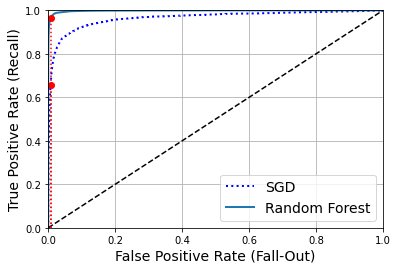

In [43]:
# Find the true positive rate when the false positive rate is greater than fpr_90
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

# Plot true positive rates against false positive rates from our SGD classifier with a blue dotted line.
plt.plot(fpr, tpr, "b:", linewidth = 2, label = "SGD")

# Plot true positive rates against false positive rates from our random forest classifier.
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

# Plot red dotted line from (fpr_90, 0) to (fpr_90, recall_90_precision).
plt.plot([fpr_90, fpr_90], [0, recall_90_precision], "r:")

# Plot red dotted line from (0, recall_90_precision) to (fpr_90, recall_90_precision).
plt.plot([0, fpr_90], [recall_90_precision, recall_90_precision], "r:")

# Plot red point at (fpr_90, recall_90_precision).
plt.plot([fpr_90], [recall_90_precision], "ro")

# Plot red dotted line from (fpr_90, 0) to (fpr_90, recall_for_forest).
plt.plot([fpr_90, fpr_90], [0, recall_for_forest], "r:")

# Plot red point at (fpr_90, recall_for_forest).
plt.plot([fpr_90], [recall_for_forest], "ro")

# Add grid background.
plt.grid(True)

# Place the legend on the lower right of the visualisation.
plt.legend(loc = "lower right", fontsize = 14)
plt.show()

As you can see, the `RandomForestClassifier's` ROC curve looks much better than the `SGDClassifier`'s: it comes much closer to the top-left corner. As a result its ROC AUC score is also significantly better:

In [44]:
# Calculate the area under the ROC curve for our random forests classifier.
round(roc_auc_score(y_train_5, y_scores_forest), 4)

0.9984

Try measuring the precision & recall scores: you should find 99% precision & ~ 87% recall. Not bad!

In [45]:
# Generate the cross-validated predictions of each sample in our training set.
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 5)

# Calculate the precision & recall scores of our random forest model.
ps = round(precision_score(y_train_5, y_train_pred_forest), 4)
rs = round(recall_score(y_train_5, y_train_pred_forest), 4)
print("Precision Score: {}, Recall Score {}".format(ps, rs))

Precision Score: 0.991, Recall Score 0.8735


Hopefully you now know how to train binary classifiers, choose the appropriate metric for your task, evaluate your classifiers using cross-validation, select the precision/recall tradeoff that fits your needs, & compare various models using ROC curves & ROC AUC scores. Now let's try to detect more than just the 5s.

---

# Multiclass Classification

Whereas binary classifiers distinguish between two classes, *multiclass classifiers* (aka. *multinomial classifiers*) can distinguish between more than two classes.

Some algorithms (such as random forest classifiers or naive bayes classifiers) are capable of handling multiple classes directly. Others (such as support vector machine classifiers or linear classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers.

For example, one way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, & so on). Then when you want to classify an image, you get the decision score from each classifier for that image & you select the class whose classifier outputs the highest score. This is called the *one-versus-all* (OvA) strategy.

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s & 1s another to distinguish 0s & 2s, another for 1s & 2s, & so on. This is called the *one-versus-one* (OvO) strategy. If there are *N* classes, you need to train $\frac{N(N - 1)}{2}$ classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers & see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms (such as support vector machine classifiers) scale poorly with the size of the training set, so for these algorithms, OvO is preferred since it is faster to train many classifiers on small training sets than training few classifiers on large training sets. For most binary classification algorithms, however, OvA is preferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, & it automatically runs OvA (except for SVM classifiers for which it uses OvO). Let's try this with the `SGDClassifier`.

In [46]:
# Fit our SGDClassifier to our training set, classifying all labels 0-9.
sgd_clf.fit(X_train, y_train)

# Using our SGDClassifier, predict some_digit's class.
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

That was easy! We trained the `SGDClassifier` on the training set using the original target classes from 0 to 9 (`y_train`), instead of the 5-versus-all target classes (`y_train_5`). Then it makes a prediction (a incorrect one in this case, it predicts that some_digit is a 3, when it is actually a 5). Under the hood, scikit-learn actually trained 10 binary classifiers, got their decision scores for the image, & selected the class with the highest score.

To see that this is indeed the case, you can call the `decision_function()` method. Instead of returning just one score per instance, it now returns 10 scores, one per class:

In [47]:
# Generate the confidence scores that some_digit belongs to any given class (0 - 9).
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

The highest score is indeed the one corresponding to class 3:

In [48]:
# Get the class for some_digit with the largest confidence score.
np.argmax(some_digit_scores)

3

If you want to force scikit-learn to use one-versus-one or one-versus-all, you can use the `OneVsOneClassifier` or `OneVsRestClassifier` classes. Simply create an instance & pass a binary classifier to its constructor. For example, this code creates a multiclass classifier using the OvO strategy, based on a `SGDClassifier`.

In [49]:
from sklearn.multiclass import OneVsOneClassifier

# Create a one-versus-one instance of our SGDClassifier.
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))

# Fit our OvO SGDClassifier to our training set.
ovo_clf.fit(X_train, y_train)

# Use our OvO SGDClassifier to predict some_digit
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

Training a `RandomForestClassifier` is just as easy.

In [50]:
# Create a one-versus-one instance of our random forest classifier.
forest_clf = RandomForestClassifier(random_state = 42)

# Fit our OvO random forest classifier to our training set.
forest_clf.fit(X_train, y_train)

# Use our OvO random forest classifier to predict the class of some_digit.
forest_clf.predict([some_digit])

array([5], dtype=uint8)

This time, scikit-learn did not have to run OvA or OvO because random forest classifiers can directly classify instances into multiple classes. You can call `predict_proba()` to get the list of probabilities that the classifier assigned to each instance for each class:

In [51]:
# Using our OvO random forest classifier, predict the probabilities that some_digit belongs to each class (0 - 9).
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

You can see that the classifier is fairly confident about its prediction: the 0.9 at the 5th index in the array means that the model estimates a 90% probability that the image represents a 5. It also thinks that the image could instead be a 2, a 3, or a 9, respectively with 1%, 8%, & 1% probability.

Now, of course, you want to evaluate these classifiers. As usual, you want to use cross-validation. Let's evaluate the `SGDClassifier's` accuracy using the `cross_val_score()` function.

In [52]:
# Generate the cross-validated accuracy for our SGDClassifier.
cross_val_score(sgd_clf, X_train, y_train, cv = 5, scoring = "accuracy")

array([0.88083333, 0.88325   , 0.88116667, 0.86625   , 0.8875    ])

It gets over 85% on all folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can do much better. For example, simply scaling the inputs increases accuracy above 89%.

In [53]:
from sklearn.preprocessing import StandardScaler

# Create a standard scaler instance.
scaler = StandardScaler()

# Scale the numeric features in our training set (all features).
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

# Generate the cross-validated accuracy scores for our scaled SGDClassifier.
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 5, scoring = "accuracy")

array([0.89733333, 0.88725   , 0.89583333, 0.89233333, 0.90516667])

---

# Error Analysis

Of course, if this were a real project, you would follow the steps of the machine learning pipeline: exploring data preparation options, trying out multiple models, shortlisting the best ones & fine tuning their hyperparameters using `GridSearchCV`, & automating as much as possible. Here, we will assume you have found a promising model & you want to find ways to improve it. One way to do this is to analyse the types of errors it makes.

First, you can look at the confusion matrix. You need to make predictions using the `cross_val_predict()` function, then call the `confusion_matrix()` function, just like you did before.

In [54]:
# Get the cross_validated predictions of scaled training set ran on the SGD classifier.
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 5)

# Generate the confusion matrix based on the resulting predictions.
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5570,    0,   15,    3,    9,   39,   33,    5,  248,    1],
       [   0, 6408,   41,   21,    3,   41,    4,    7,  208,    9],
       [  26,   25, 5220,   85,   67,   24,   62,   37,  401,   11],
       [  26,   18,  107, 5187,    0,  184,   24,   39,  483,   63],
       [  10,   13,   36,    9, 5183,   10,   34,   20,  381,  146],
       [  26,   18,   23,  155,   51, 4401,   77,   13,  596,   61],
       [  26,   17,   41,    2,   40,   83, 5548,    7,  154,    0],
       [  20,   11,   52,   23,   48,   11,    3, 5685,  217,  195],
       [  16,   58,   37,   88,    2,  119,   28,    8, 5459,   36],
       [  21,   19,   28,   58,  119,   30,    1,  170,  429, 5074]])

That's a lot of numbers. It's often more convenient to look at an image representation of the confusion matrix, using matplotlib's `matshow()` function.

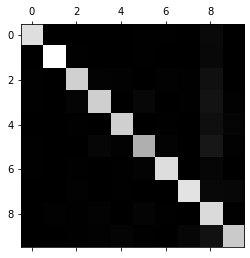

In [55]:
# Show our confusion matrix on gray scale.
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

This confusion matrix looks fairly good, since most of the images are on the main diagonal, which means that they were classified correctly. The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits. In fact, you can verify that both are the case.

Let's focus the plot on the errors. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class, so you can compare error rates instead of absolute number of errors (which would make abundant classes look unfairly bad):

In [56]:
# Calculate the ACTUAL number of images in each corresponding class (row-level sums).
row_sums = conf_mx.sum(axis = 1, keepdims = True)
            
# Divide confusion matrix value by number of images in corresponding class for error rates.
norm_conf_mx = conf_mx / row_sums

Now let's fill the diagonal with zeros to keep only the errors, & let's plot the result.

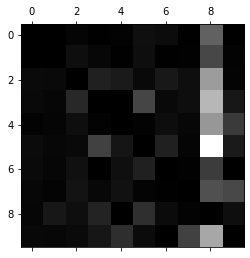

In [57]:
np.fill_diagonal(norm_conf_mx, 0)

# Show our error rate confusion matrix in grey scale.
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

Now you can clearly see the kinds of errors the classifier makes. Remember that rows represent actual classes, while columns represent predicted classes. The column for class 8 is quite bright, which tells you that many images get misclassified as 8s. However, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s. As you can see, the confusion matrix is not necessarily symmetrical. You can see that 3s & 5s often get confused (in both directions).

Analysing the confusion matrix can often give you insights on ways to improve your classifier. Looking at this plot, it seems that your efforts should be spent on reducing the false 8s. For example, you could try to gather more training data for digits that look like 8s (but are not) so the classifier can learn to distinguish them from real 8s. Or you could engineer new features that would help the classifier -- for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns stand out more, such as closed loops.

Analysing individual errors can also be a good way to gain insights on what your classifier is doing & why it is failing, but it is more difficult & time-consuming. For example, let's plot examples of 3s & 5s (the `plot_digits()` function just uses matplotlib's `imshow()` function).

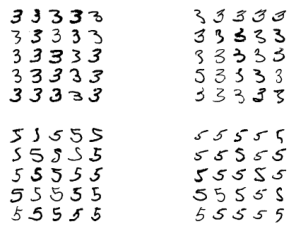

In [59]:
cl_a, cl_b = 3, 5

# Get samples of the training set where the label is 3 & our scaled SGD classifier prediction is 3.
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]

# Get samples of the training set where the label is 3 & our scaled SGD classifier prediction is 5.
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]

# Get samples of the training set where the label is 5 & our scaled SGD classifier prediction is 3.
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]

# Get samples of the training set where the label is 5 & our scaled SGD classifier prediction is 5.
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

# Plots multiple digit images.
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

# Plot the first 25 samples that our scaled SGDClassifier predicted was 3 & was labeled as 3, in a 5x5 subplot.
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)

# Plot the first 25 samples that our scaled SGDClassifier predicted was 5 & was labeled as 3, in a 5x5 subplot.
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)

# Plot the first 25 samples that our scaled SGDClassifier predicted was 3 & was labeled as 5, in a 5x5 subplot.
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)

# Plot the first 25 samples that our scaled SGDClassifier predicted was 5 & was labeled as 5, in a 5x5 subplot.
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)
plt.show()

The two 5x5 blocks on the left show digits classified as 3s, & the two 5x5 blocks on the right show images classified as 5s. Some of the digits that the classifier gets wrong (i.e., in the bottom-left & top-right blocks) are so badly written that even a human would have trouble classifying them (e.g., the 5 on the 1st row & 2nd column truly looks like a badly written 3). However, most misclassified images seem like obvious errors to us, & it's hard to understand why the classifier made the mistakes it did. The reason is that we used a simple `SGDClassifier`, which is a linear model. All it does is assign a weight per class to each pixel, & when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s & 5s differ only by a few pixels, this model will easily confuse them.

The main difference between 3s & 5s is the position of the small line that joins the top line to the bottom arc. If you draw a 3 with the junction slightly shifted to the left, the classifier might classify it as a 5, & vice versa. In other words, this classifier is quite sensitive to image shifting & rotation. So one way to reduce the 3/5 confusion would be to preprocess the images to ensure that they are well centered & not too rotated. This will help reduce other errors as well.

---

# Multilabel Classification

Until now, each instance has always been assigned to just one class. In some cases, you may want your classifier to output multiple classes for each instance. For example, consider a face-recognition classifier: what should it do if it recognises several people on the same picture? Of course, it should attach one tag per person it recognises. Say the classifier has been trained to recognise three faces, Alice, Bob & Charlie; then when it is shown a picture of Alice & Charlie, it should output [1, 0, 1] (meaning "Alice yes, Bob no, Charlie yes"). Such a classification system that outputs multiple binary tags is called a *multilabel classification system*.

We won't cover facial recognition just yet, but let's look at a simpler example, just for illustration purposes.

In [60]:
from sklearn.neighbors import KNeighborsClassifier

# Returns True if training set labels is greater than or equal to 7.
y_train_large = (y_train >= 7)

# Returns True if training set labels is an odd number.
y_train_odd = (y_train % 2 == 1)

# Binds labels together like columns, "c_" (If np.r_, binds labels together like rows). 
y_multilabel = np.c_[y_train_large, y_train_odd]

# Create a KNeighborsClassifier instance.
knn_clf = KNeighborsClassifier()

# Fit the KNeighborsClassfier instance to our training set with the multilabel.
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

This code creates a `y_multilabel` array containing two target labels for each digit image: the first indicates whether or not the digit is large (7, 8, or 9) & the second indicates whether or not it is odd. The next line creates a `KNeighborsClassifier` instance (which supports multilabel classification, but not all classifiers do) & we train it using the multiple targets array. Now you can make a prediction, & notice that it outputs two labels.

In [61]:
# Predict the multilabel of our training set using the KNeighborsClassifier instance.
knn_clf.predict([some_digit])

array([[False,  True]])

& it gets it right. The digit 5 is indeed not large (`False`) & odd (`True`).

There are many ways to evaluate a multilabel classifier & selecting the right metric really depends on your project. For example, one approach is to measure the F1 score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score. This code computes the average F1 score across all labels.

In [62]:
# Get the cross-validated predictions (multilabels) for each sample of the training set.
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 5)

# Calculate the F1 Score.
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

0.977511478985599

This assumes that all labels are equally important, which may not be the case. In particular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier's score on pictures of Alice. One simple option is to give each label a weight equal to its *support* (i.e., the number of instances with that target label). To do this, simply set `average = "weighted"` in the preceding code.

---

# Multioutput Classification

The last type of classification task we are going to discuss is called *multioutput-multiclass classification* (or simply *multioutput classification*). It is simply a generalisation of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

To illustrate this, let's build a system that removes noise from images. It will take, an input, a noisy digit image, & it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier's output is multilabel (one label per pixel) & each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of an multioutput classification system.

Let's start by creating the training & test sets by taking the MNIST images & adding noise to their pixel intensities using NumPy's `randint()` function. The target images will be the original images.

In [63]:
# Add noise to the training set features.
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

# Add noise to the test set features.
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

# Get unmodified training & test set features.
y_train_mod = X_train
y_test_mod = X_test

Let's take a peek at an image from the test set (yes, we're snooping on the test data, so you should be frowning right now).

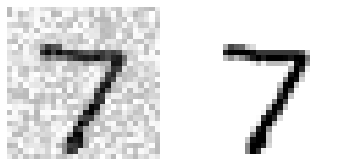

In [66]:
some_index = 0

# Plots a digit image.
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

# Plot the first sample in the noisy test set.
plt.subplot(121); plot_digit(X_test_mod[some_index])

# Plot the first sample in the unmodified test set.
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

On the left is the noisy input image, & on the right is the clean target image. Now let's train the classifier & make it clean this image.

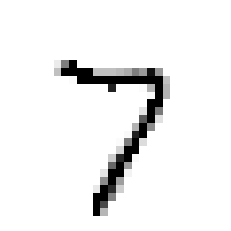

In [67]:
# Fit a KNeighboursClassifier to our noisy training set.
knn_clf.fit(X_train_mod, y_train_mod)

# Use our KNeighboursClassifier to predict the first sample in our noisy test set.
clean_digit = knn_clf.predict([X_test_mod[some_index]])

# Plot he predicted class of the sample.
plot_digit(clean_digit)

Looks close enough to the target! This concludes our tour of classification. Hopefully, you should now know how to select good metrics for classification tasks, pick the appropriate precision/recall tradeoff, compare classifiers, & more generally build good classification systems for a variety of tasks.